In [1]:
#%pip install langchain
#%pip install langchain_openai

# Import Necessary Libraries

import os
import getpass
from llama_index.core import SimpleDirectoryReader
from llama_index.core.ingestion import IngestionPipeline
from llama_index.core.node_parser import SentenceSplitter
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.extractors import TitleExtractor
from llama_index.core import VectorStoreIndex
from dotenv import load_dotenv
from llama_index.llms.openai import OpenAI

import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext
from llama_index.core import Settings

from langchain_openai import ChatOpenAI
from langchain_community.utilities import SerpAPIWrapper

import nest_asyncio
from diskcache import Cache
from IPython.display import Image, display

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver

import openai

c:\Users\sandy\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Apply nested asyncio to allow for nested event loops
nest_asyncio.apply()

# Ask user for OpenAI API key and set it
print("Enter your OpenAI API key: Please Note this is a demo version, only openai is currently supported. Input is hidden")
api_key = getpass.getpass()
openai.api_key = api_key

# Initialize a persistent Chroma database client with the specified path
chroma_client = chromadb.PersistentClient(path="./chroma.db")

# Define the path to the directory containing PDF documents to be processed
pdf_dir_path = "./dataset_folder"

# Set the language model and embedding model to be used for processing
Settings.llm = OpenAI(model="gpt-4o-mini")
Settings.embed_model = OpenAIEmbedding()

# Initialize a cache to store results, with a specified cache directory
cache = Cache("./cache")
#Settings.embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")

Enter your OpenAI API key: Please Note this is a demo version, only openai is currently supported. Input is hidden


In [3]:
def build_index(pdf_dir_path, storage_context):
    """Builds a vector store index from PDF documents.

    Args:
        pdf_dir_path (str): The path to the directory containing PDF documents to be indexed.
        storage_context (StorageContext): The context for storing the vector index.

    Returns:
        VectorStoreIndex: The created vector store index containing the processed documents.
    """  
    # Load documents from the specified directory
    docs = SimpleDirectoryReader(pdf_dir_path).load_data()
    
    # Create an ingestion pipeline with specified transformations
    pipeline = IngestionPipeline(
        transformations=[
            # Split documents into sentences with specified chunk size and overlap
            SentenceSplitter(chunk_size=2048, chunk_overlap=0),
            # Extract titles from the documents
            TitleExtractor(),
            # Use OpenAI's embedding model for text embedding
            OpenAIEmbedding(model_name="text-embedding-ada-002"),
            #HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2"),
        ]
    )
    
    # Run the pipeline on the loaded documents to create nodes
    nodes = pipeline.run(documents=docs)
    
    # Create a vector store index from the nodes and the provided storage context
    index = VectorStoreIndex(nodes=nodes, storage_context=storage_context)

    return index  # Return the created index

In [4]:

def data_retrieval(query, index):
    """Retrieves data based on the provided query from the specified index.

    Args:
        query (str): The query string used to search for relevant data.
        index (VectorStoreIndex): The index from which to retrieve data.

    Returns:
        list: A list of results matching the query.
    """
    # Convert the index into a retriever object for querying
    retriever = index.as_retriever()
    
    # Retrieve results based on the provided query
    results = retriever.retrieve(query)
    
    return results  # Return the retrieved results

In [5]:
def save_index():
    """Creates and saves a vector store index from PDF documents.

    This function attempts to create a new Chroma collection for storing the index.
    If the collection already exists, it retrieves the existing collection.
    It then builds the index from the documents in the specified directory and saves it.

    Returns:
        VectorStoreIndex or None: The created vector store index if successful, otherwise None.
    """
    print("Creating and saving the index")
    
    # Attempt to create a new Chroma collection for storing the index
    try:
        chroma_collection = chroma_client.create_collection(name="Insurance_Doc_RAG_LlamaIndex_LangGraph")
    except Exception as e:
        # If the collection already exists, retrieve the existing collection
        print(f"Collection already exists: {e}")
        chroma_collection = chroma_client.get_collection(name="Insurance_Doc_RAG_LlamaIndex_LangGraph")

    # Initialize a vector store with the Chroma collection
    vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
    
    # Create a storage context using the default settings and the vector store
    storage_context = StorageContext.from_defaults(vector_store=vector_store)

    # Attempt to build the index from the documents and save it
    try:
        index = build_index(pdf_dir_path, storage_context)
        print("Index created and saved")
        return index  # Return the created index
    except Exception as e:
        # If an error occurs during index building, print the error and return None
        print(f"Error while building the index: {e}")
        return None

In [6]:
def load_index():
    """Loads the vector store index from a Chroma collection.

    This function attempts to load a vector store index from a specified Chroma collection.
    If the collection exists, it retrieves the collection and constructs a vector store index.
    If the collection does not exist or an error occurs, it returns None.

    Returns:
        VectorStoreIndex or None: The loaded vector store index if successful, otherwise None.
    """
    # Attempt to retrieve the specified collection from the Chroma database
    try:
        chroma_collection = chroma_client.get_collection(name="Insurance_Doc_RAG_LlamaIndex_LangGraph")
    except Exception as e:
        # Print an error message if the collection cannot be loaded
        print(f"Error loading the collection: {e}")
        return None

    print("Loading the index")
    # Initialize a ChromaVectorStore with the retrieved collection
    vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
    # Create a storage context using default settings and the vector store
    storage_context = StorageContext.from_defaults(vector_store=vector_store)

    try:
        # Attempt to create a VectorStoreIndex from the vector store and storage context
        index = VectorStoreIndex.from_vector_store(
            vector_store=vector_store,
            storage_context=storage_context
        )
        return index  # Return the successfully loaded index
    except Exception as e:
        # Print an error message if the index cannot be loaded
        print(f"Error while loading the index: {e}")
        return None  # Return None if the index cannot be created

In [7]:
# Attempt to load the existing vector store index
index = load_index()

# If loading the index fails, attempt to create and save a new index
if index is None:
    index = save_index()

# Check if the index is successfully loaded or created
if index:
    print("Index is ready")  # Indicate that the index is ready for use
else:
    print("Failed to create or load the index")  # Indicate failure in loading or creating the index

Error loading the collection: Collection Insurance_Doc_RAG_LlamaIndex_LangGraph does not exist.
Creating and saving the index


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Index created and saved
Index is ready


In [8]:
def retrive_docs(query):
    """Retrieves documents based on the provided query, utilizing a cache for efficiency.

    This function first checks if the results for the given query are already cached. 
    If cached results are found, they are returned immediately. 
    If not, it retrieves the results from the index and caches them for future use.

    Args:
        query (str): The query string used to search for relevant documents.

    Returns:
        list: A list of results matching the query.
    """
    # Check if the results for the query are already in the cache
    if cache.get(query) is not None:
        return cache.get(query)  # Return cached results if available
    
    # Retrieve results from the index if not cached
    results = data_retrieval(query, index)
    
    # Store the retrieved results in the cache with a specified expiration time
    cache.set(query, results, expire=600)

    return results  # Return the retrieved results

# Uncomment the following line to test the function with a sample query
# res = retrive_docs("what is Waiting Period and Exclusions?")
# print(res)  # Uncomment to print the results

In [9]:
@tool
def search_tool(query: str):
    """BACKUP TOOL - Only use this tool if docs_tool fails to provide relevant information 
    or returns incomplete results. This tool searches external sources."""
    # Use the SerpAPIWrapper to perform a search on external sources using the provided query
    return SerpAPIWrapper(serpapi_api_key ="663d549846fac3c10e2b7d0dfeed509b0923c171084ecf2b8b4574bef5b3683a").run(query)

@tool
def docs_tool(query: str):
    """PREFERRED TOOL - Use this tool FIRST to search internal documentation and get information. 
    Only use other tools if this tool fails to provide relevant information."""
    # Retrieve documents based on the query using the internal retrieval function
    return retrive_docs(query)

In [11]:
# List of tools to be used, with docs_tool as the primary and search_tool as the backup
tools = [docs_tool, search_tool]

# Create a ToolNode that manages the defined tools
tool_node = ToolNode(tools)

# Initialize the language model with the specified model
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1, api_key=api_key)

# Bind the tools to the language model for enhanced functionality
llm_with_tools = llm.bind_tools(tools)

In [16]:
# Please Note - The following piece of code is not required to run the application and could/is used for internal understanding, alternate
# prototyping ways and testing/debugging purposes. This code is not required to run this application which the code used above/below has superseded. 

# from typing import Annotated, List
# from typing_extensions import TypedDict

# from langchain_openai import ChatOpenAI
# from langgraph.graph import StateGraph, START, END
# from langgraph.graph.message import add_messages
# from langgraph.prebuilt import ToolNode, tools_condition

# class State(TypedDict):
#     messages: List[dict]

# graph_builder = StateGraph(State)

# llm = ChatOpenAI(model="gpt-4o-mini")

# llm_with_tools = llm.bind_tools(tools)

# def chatbot(state: State):
#     return {"messages" : [llm_with_tools.invoke(state["messages"])]}

# tool_node = ToolNode(
#     tools =[docs_tool, search_tool]
# )

# graph_builder.add_node("chatbot", chatbot)
# graph_builder.add_node("tools", tool_node)

# graph_builder.add_edge("tools", "chatbot")
# graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")

# graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge("chatbot", END)

# graph = graph_builder.compile()

# llm_with_tools.invoke("What is the procedure to claim the insurance?").tool_calls

# tool_node.invoke({"messages": [llm_with_tools.invoke("What is the procedure to claim the insurance?")]})

# for chunk in app.stream(
#     {"messages": [("human", "what is Accelerated Critical Illness Benefit in the Insurance Doc?")]}, stream_mode="values"
# ):
#     chunk["messages"][-1].pretty_print()
# data = []

# for chunk in app.stream(
#     {"messages": [("human", "what is Accelerated Critical Illness Benefit in the Insurance Doc?")]}, stream_mode="values"
# ):
#     data.append(chunk["messages"][-1].content)

In [12]:
def should_continue(state: MessagesState):
    """Determines whether the conversation should continue based on the last message.

    This function checks the last message in the conversation state to see if it contains any tool calls.
    If tool calls are present, it indicates that the conversation should continue with tool usage.
    Otherwise, it signals the end of the conversation.

    Args:
        state (MessagesState): The current state of the conversation, including messages.

    Returns:
        str: "tools" if there are tool calls in the last message, otherwise returns END.
    """
    # Extract the list of messages from the conversation state
    messages = state["messages"]
    
    # Get the last message in the conversation
    last_message = messages[-1]
    
    # Check if the last message contains any tool calls
    if last_message.tool_calls:
        return "tools"  # Indicate that the conversation should continue with tools
    
    return END  # Indicate that the conversation should end

In [13]:
def call_model(state: MessagesState):
    """Invokes the language model with the current conversation messages.

    This function takes the current state of the conversation, extracts the messages,
    and passes them to the language model for processing. It returns the model's response
    in a structured format.

    Args:
        state (MessagesState): The current state of the conversation, including messages.

    Returns:
        dict: A dictionary containing the model's response wrapped in a list under the key "messages".
    """
    # Extract the list of messages from the conversation state
    messages = state["messages"]

    #print(messages)
    # Add a prompt to the messages.
    prompt = """
    Give the reference of the document i.e page number and document name if you got the answer from the document. 
    If you got the answer from internet search, tell the same.
    The response format should be:
    <Answer>
    <Reference>
    reference format : Page Number | Page Title | Document Name
    Example: Page 16 | Comprehensive Guide to Insurance Policy Administration: Managing Claims, Eligibility, and Member Information Requirements | HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf
    if you got the answer from internet search, Say "Answer retrieved from internet search. Please contact the Agent/Customer Care executive for more details" in Reference.
    """
    
    # Invoke the language model with the current messages to get a response

    from langchain_core.messages import HumanMessage

    messages.append(HumanMessage(content=prompt))
    response = llm_with_tools.invoke(messages)
    
    # Return the response in a structured format
    return {"messages": [response]}

In [14]:
# Create a state graph to manage the flow of the conversation
workflow = StateGraph(MessagesState)

# Add a node for the agent that will handle the conversation logic
workflow.add_node("agent", call_model)

# Add a node for the tools that can be used during the conversation
workflow.add_node("tools", tool_node)

# Define the starting point of the workflow, connecting the START node to the agent
workflow.add_edge(START, "agent")

# Add conditional edges to determine the next step based on the agent's response
# If the agent's response indicates tool usage, transition to the tools node; otherwise, end the conversation
workflow.add_conditional_edges("agent", should_continue, ["tools", END])

# Connect the tools node back to the agent to allow for repeated tool usage
workflow.add_edge("tools", "agent")

memory = MemorySaver()

# Compile the workflow into an executable application
app = workflow.compile(checkpointer=memory)

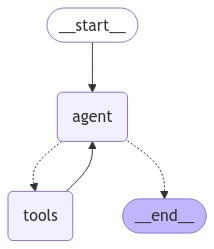

In [15]:
# Display the workflow graph as a Mermaid diagram using the application's graph representation
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# Please Note - The following piece of code is not required to run the application and is used for internal understanding, alternate
# prototyping ways and testing/debugging purposes. This code is not required to run this application which the code used above/below has superseded. 

# def stream_graph_updates(user_input: str):
#     for event in graph.stream({"messages": [("user", user_input)]}):
#         for value in event.values():
#             print("Assistant:", value["messages"][-1].content)


# while True:
#     user_input = input("User: ")
#     if user_input.lower() in ["quit", "exit", "q"]:
#         print("Goodbye!")
#         break

#     stream_graph_updates(user_input)

# print("Welcome to Insurance Documentation Chatbot. Please enter your query. Type 'exit' to quit.")
# chat_history = []
# query = input()
# print("User: ", query)
# while query != 'exit':
#     response = agent.invoke({"input": query})
#     #chat_history.append({"input": query, "output": response['output']})
#     #cache.set(response['input'], response['output'], expire=600)
#     print("Chatbot: ", response['output'])
#     query = input()
#     print("User: ", query)

# if 'exit' in query.lower():
#     print("Thanks for using Insurance Documentation Chatbot. Have a great day!")



# #agent.run("What is the procedure to claim the insurance?")

In [16]:
# Add a thread ID to the configuration for saving the conversation.
# This ensures that each conversation is saved and context is retained.

config = {"configurable" : {"thread_id" : "2"}}

In [19]:
# Welcome message for the user and instructions on how to exit the chatbot
print("Welcome to Insurance Documentation Chatbot. Please enter your query. Type 'exit' to quit.")

# Get the user's input query and print it to the Output cell
query = input()

# Continue the conversation until the user types 'exit'
while query != 'exit':
    print("User: ", query)
    print("Searching... Please wait!")
    print("-"*100)
    data = []  # Initialize a list to store the chatbot's responses
    
    # Stream the chatbot's responses based on the user's query
    for chunk in app.stream({"messages": [("human", query)]}, stream_mode="values", config=config):
        #print(chunk)  # Print the raw response chunk. Uncomment this for debugging
        data.append(chunk["messages"][-1].content)  # Append the chatbot's response to the data list
    
    # Print the last response from the chatbot
    print("Chatbot: ", data[-1])

    print("-"*100)
    
    # Get the next query from the user
    query = input()
    

# Thank the user for using the chatbot when they exit
if 'exit' in query.lower():
    print("Thanks for using Insurance Documentation Chatbot. Have a great day!")
    print("-"*100)

Welcome to Insurance Documentation Chatbot. Please enter your query. Type 'exit' to quit.
User:  is Alzheimer's Disease covered under critical illness benefits?
Searching... Please wait!
----------------------------------------------------------------------------------------------------
Chatbot:  Yes, Alzheimer's Disease is covered under critical illness benefits as specified in the policy document.

Page 28 | Comprehensive Guide to Critical Medical Conditions and Their Definitions for Insurance Coverage | HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf
----------------------------------------------------------------------------------------------------
User:  What is a Grievance Redressal Process?
Searching... Please wait!
----------------------------------------------------------------------------------------------------
Chatbot:  The Grievance Redressal Process is a structured procedure that allows policyholders to address their complaints or grievances regarding insur